In [1]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import pandas as pd
import matplotlib.cm as cm

mp.mp.dps = 100

T_c = 2/(np.log(1+np.sqrt(2)))
# T = np.linspace(T_c - 1 , T_c + 1, 3)
T=[T_c]

X_vals = [6, 8]

Y_vals = [8, 10, 12, 14, 16]

probs = [0]

alpha=0.8

beta=0.000001

walker_wl=8

overlap_wl=0.25

seed_hist=1

seed_run=42

num_interactions=100

replica_exchange_steps=50

boundary_type=0

boundary = {0: "periodic", 1: "open", 2: "cylinder"}

intervals_wl=[20]

iterations=[5000]

num_walker_prerun=150

num_intervals_prerun=30

end_seed=((seed_hist + num_interactions - 1))

# ------------------------------------------------------------

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")

    return data

def linear_fit(x, m, b):
    return m * x + b

def fit_function_five_params(x, y, A, B, C, D, E):
    return A + B / x + C / (x * y) + D * np.exp(E * y / x) / (x * y)

def fit_wrapper_five_params(xy, A, B, C, D, E):
    x, y = xy
    return fit_function_five_params(x, y, A, B, C, D, E)


def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res


def process_data(data, batch_results: list, p, x, y, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'x': x,
                'y': y,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })

# ------------------------------------------------------
# Reading results here

results = []
for interval in intervals_wl:
    for iteration in iterations:
        for x in X_vals:
            for y in Y_vals:
                for p in probs:
                    res = []
                    for error in ["I"]:
                        filename = f"../results/{boundary[boundary_type]}/prob_{p:.6f}/X_{x}_Y_{y}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iteration}_overlap_{overlap_wl:.6f}_walkers_{walker_wl}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{replica_exchange_steps}.txt"
                        try:
                            data = read_results_file(filename)
                            if data:
                                process_data(data, results, p, x, y, error)
                        except:
                            print(f"not found: {filename}")

results_df = pd.DataFrame()
for t in T:
    results_t_df = pd.DataFrame(results)
    results_t_df['free_energy'] = results_t_df.apply(lambda row: free_energy(row['E'], row['log_g'], t), axis=1)
    results_t_df['temp'] = t
    results_t_df['free_energy'] = results_t_df['free_energy'].astype(float)
    results_df = pd.concat([results_df, results_t_df], ignore_index=True)


In [2]:
results_df

,prob,x,y,error,histogram_seed,run_seed,E,log_g,free_energy,temp
0,0,6,8,I,14,48,"[-96, -88, -84, -80, -76, -72, -68, -64, -60, ...","[0.6827966934, 4.5485353237, 5.2262394196, 7.8...",-102.697823,2.269185
1,0,6,8,I,23,48,"[-96, -88, -84, -80, -76, -72, -68, -64, -60, ...","[0.7082594701, 4.5556873151, 5.2522391149, 7.9...",-102.733135,2.269185
2,0,6,8,I,39,48,"[-96, -88, -84, -80, -76, -72, -68, -64, -60, ...","[0.7308942725, 4.6075136115, 5.2940861632, 7.9...",-102.863513,2.269185
3,0,6,8,I,49,48,"[-96, -88, -84, -80, -76, -72, -68, -64, -60, ...","[0.693834741, 4.5724980424, 5.2555303167, 7.91...",-102.787872,2.269185
4,0,6,8,I,1,48,"[-96, -88, -84, -80, -76, -72, -68, -64, -60, ...","[0.6326226929, 4.5514964798, 5.2534293869, 7.8...",-102.699256,2.269185
...,...,...,...,...,...,...,...,...,...,...
595,0,8,64,I,17,59,"[-1024, -1016, -1012, -1008, -1004, -1000, -99...","[0.6164701351, 6.8592660793, 7.5525727638, 12....",-1084.771454,2.269185
596,0,8,64,I,15,59,"[-1024, -1016, -1012, -1008, -1004, -1000, -99...","[0.5775330675, 6.7953370225, 7.4937282217, 12....",-1084.739731,2.269185
597,0,8,64,I,42,59,"[-1024, -1016, -1012, -1008, -1004, -1000, -99...","[0.6630757842, 6.9191428218, 7.6150201354, 12....",-1084.876699,2.269185
598,0,8,64,I,21,59,"[-1024, -1016, -1012, -1008, -1004, -1000, -99...","[0.6697324279, 6.9119766715, 7.6094287398, 12....",-1084.958612,2.269185


In [3]:
aggregated_results_df = results_df.groupby(['prob', 'x', 'y', 'error', 'temp']).agg(
    avg_free_energy=('free_energy', 'mean'),
    var_free_energy=('free_energy', 'var')
).reset_index()
aggregated_results_df

,prob,x,y,error,temp,avg_free_energy,var_free_energy
0,0,6,8,I,2.269185,-102.688226,0.007866
1,0,6,10,I,2.269185,-128.057738,0.008843
2,0,6,12,I,2.269185,-153.479119,0.010144
3,0,6,14,I,2.269185,-178.917842,0.011741
4,0,6,16,I,2.269185,-204.333208,0.011553
5,0,6,64,I,2.269185,-816.525850,0.014592
6,0,8,8,I,2.269185,-136.417679,0.009163
7,0,8,10,I,2.269185,-170.210275,0.010731
8,0,8,12,I,2.269185,-203.978269,0.009924
9,0,8,14,I,2.269185,-237.815834,0.013626


In [4]:
fit_params = []
for x_val in aggregated_results_df['x'].unique():
    # Iterate over each unique temperature
    for temp_val in aggregated_results_df['temp'].unique():
        # Filter the DataFrame for the specific x and temperature
        subset_df = aggregated_results_df[(aggregated_results_df['temp'] == temp_val) & (aggregated_results_df['x'] == x_val)]

        # Ensure there are enough data points to fit
        if len(subset_df) > 1:
            print(len(subset_df))
            y_data = subset_df['y']
            free_energy_data = subset_df['avg_free_energy']
            variances = subset_df['var_free_energy']

            # Initial guess for parameters A, B, C, D, E
            initial_guess = [1, 1, 1, 1, 0.01]

            try:
                # Perform the curve fit with weights based on the variances
                weights = 1 / np.sqrt(variances)  # Inverse of standard deviations

                # Perform the curve fit
                popt, pcov = curve_fit(
                    fit_wrapper_five_params,
                    (np.full_like(y_data, x_val), y_data),  # Use x_val as a constant for all y values
                    free_energy_data,
                    p0=initial_guess,
                    sigma=np.sqrt(variances),  # Use standard deviations (sqrt of variances)
                    absolute_sigma=True  # Treat sigma as absolute standard deviations
                )

                # Extract parameters and store them along with temperature and x
                A, B, C, D, E = popt
                param_variances = np.sqrt(np.diag(pcov))
                fit_params.append((temp_val, x_val, A, B, C, D, E, param_variances))

            except RuntimeError:
                print(f"Fit could not converge for T: {temp_val}, X: {x_val}")

# Print the fit parameters and their variances for each temperature and x value
for (temp_val, x_val, A, B, C, D, E, param_variances) in fit_params:
    print(f"T = {temp_val}, X = {x_val}: A = {A:.4f} ± {param_variances[0]:.4f}, "
          f"B = {B:.4f} ± {param_variances[1]:.4f}, C = {C:.4f} ± {param_variances[2]:.4f}, "
          f"D = {D:.4f} ± {param_variances[3]:.4f}, E = {E:.4f} ± {param_variances[4]:.4f}")


6
6
T = 2.269185314213022, X = 6: A = -956.2381 ± inf, B = 1556.2761 ± inf, C = 34011.1947 ± inf, D = 539.4724 ± inf, E = -2307.3250 ± inf
T = 2.269185314213022, X = 8: A = 130.6225 ± inf, B = -8596.2928 ± inf, C = 63627.9082 ± inf, D = -779.2275 ± inf, E = -4027.6249 ± inf


/tmp/ipykernel_3548815/3783708477.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


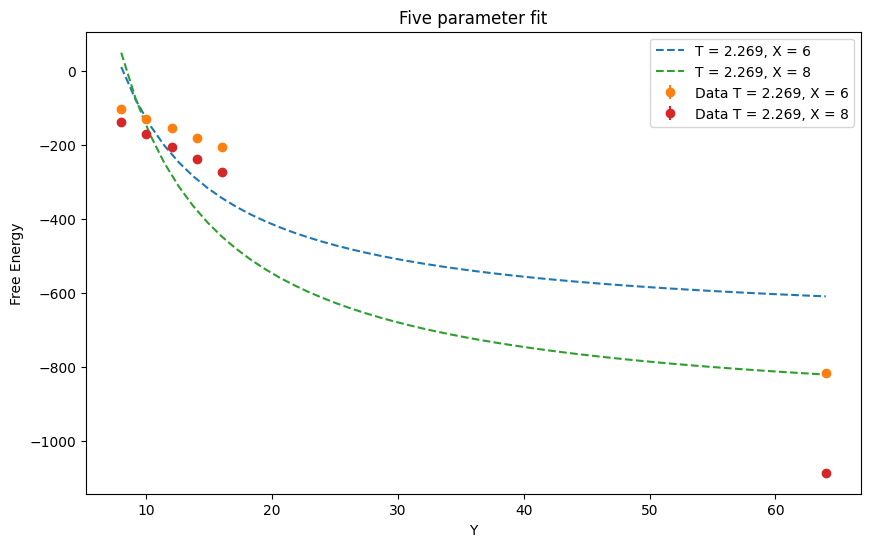

[{'temp': 2.269185314213022, 'x': 6, 'B': 1556.2760942653867, 'c': -1309.8394300369569}, {'temp': 2.269185314213022, 'x': 8, 'B': -8596.292807957612, 'c': 7235.0679378140585}]


In [5]:
# Plotting results for each fit
fig, ax = plt.subplots(figsize=(10, 6))

c_estimates=[]

for (temp_val, x_val, A, B, C, D, E, _) in fit_params:
    # Filter the DataFrame for the specific temperature and x
    subset_df = aggregated_results_df[(aggregated_results_df['temp'] == temp_val) & (aggregated_results_df['x'] == x_val)]

    y_data = subset_df['y']
    free_energy_data = subset_df['avg_free_energy']

    # Generate y values for the fitted curve
    y_range = np.linspace(min(y_data), max(y_data), 50)
    fitted_free_energy = fit_function_five_params(x_val, y_range, A, B, C, D, E)

    # Plot the fitted curve
    ax.plot(y_range, fitted_free_energy, linestyle='--', label=f'T = {temp_val:.3f}, X = {x_val}')

    # Plot the original data points with error bars
    ax.errorbar(y_data, free_energy_data, yerr=np.sqrt(subset_df['var_free_energy']), fmt='o', label=f'Data T = {temp_val:.3f}, X = {x_val}')

    c_estimates.append({
        'temp': temp_val,
        'x': x_val,
        'B': B,
        'c': -B*6/(T_c*np.pi)
    })

ax.set_xlabel('Y')
ax.set_ylabel('Free Energy')
ax.set_title('Five parameter fit')
ax.legend()
plt.show()

print(c_estimates)

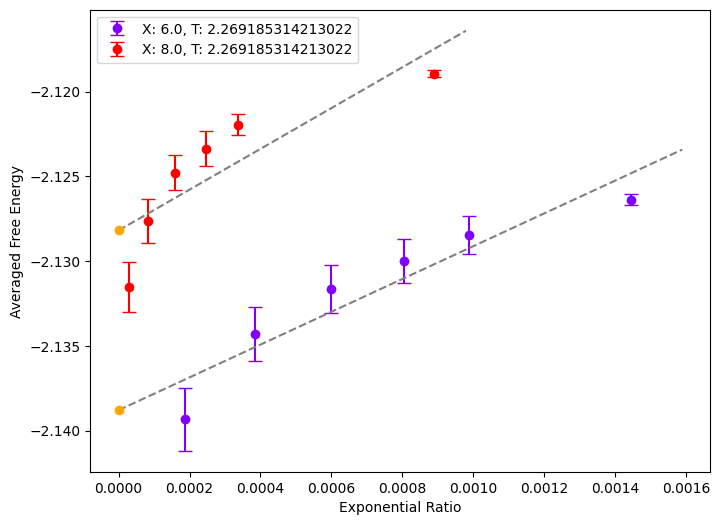

In [6]:

# Group by 'prob', 'x', 'y', 'error', 'temp' and calculate both mean and variance
aggregated_results_df = results_df.groupby(['prob', 'x', 'y', 'error', 'temp']).agg(
    avg_free_energy=('free_energy', 'mean'),
    var_free_energy=('free_energy', 'var')
).reset_index()

# Calculate the exponential ratio for extrapolating y -> inf limit but with scaling dimension 1?
aggregated_results_df['exp_ratio'] = np.exp(-2 * np.pi * aggregated_results_df['x'] / aggregated_results_df['y']) / (aggregated_results_df['y'] * aggregated_results_df['x'])

# Group the data by unique pairs of 'x' and 'temp'
unique_pairs = results_df.groupby(['x', 'temp']).size().reset_index().drop(columns=0)
colors = cm.rainbow(np.linspace(0, 1, len(unique_pairs)))

# List to store extrapolated intercepts
intercepts_data = []

# Create a plot for the extrapolation
plt.figure(figsize=(8, 6))

# Iterate over each unique pair of (x, temp)
for idx, (x_val, t_val) in unique_pairs.iterrows():
    # Filter the DataFrame for the specific x and temperature
    subset_df = aggregated_results_df[(aggregated_results_df['x'] == x_val) & (aggregated_results_df['temp'] == t_val)]

    # Ensure there are enough data points to fit
    if len(subset_df) > 1:
        exp_ratios = subset_df['exp_ratio']
        avg_free_energies = subset_df['avg_free_energy'] / (x_val * subset_df['y'])
        errors = np.sqrt(subset_df['var_free_energy']) / (x_val * subset_df['y'])

        # Fit a linear model to the data points (exp_ratio vs avg_free_energy)
        popt, pcov = curve_fit(linear_fit, exp_ratios, avg_free_energies)

        # Extrapolate to find the y-intercept (where exp_ratio = 0)
        y_intercept = linear_fit(0, *popt)

        # Calculate the variance of the intercept estimate
        # The variance of the parameters can be found in the covariance matrix (pcov)
        intercept_variance = pcov[0, 0]  # Assuming popt[0] is the intercept
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the x, t, and intercept data
        intercepts_data.append({
            'x_value': x_val,
            'temp_value': t_val,
            'intercept_free_energy': y_intercept,
            'intercept_variance': intercept_variance,
            'intercept_std_dev': intercept_std_dev
        })

        plt.errorbar(
            exp_ratios,
            avg_free_energies,
            yerr=errors,
            fmt='o', capsize=5, label=f'X: {x_val}, T: {t_val}',
            color = colors[idx]
        )

        # Plot the linear fit over the entire exp_ratio range (extrapolated)
        x_vals_for_line = np.linspace(0, max(exp_ratios) * 1.1, 100)  # Extended range for the line
        plt.plot(x_vals_for_line, linear_fit(x_vals_for_line, *popt), linestyle='--', color='gray')

        # Mark the y-intercept on the plot
        plt.scatter(0, y_intercept, color='orange', zorder=5)
        # plt.text(0, y_intercept, f'X: {x_val}, T: {t_val:.3f}, Intercept: {y_intercept:.3f}', fontsize=10)

# Create a DataFrame to store the intercept results
intercepts_df = pd.DataFrame(intercepts_data)


plt.xlabel('Exponential Ratio')
plt.ylabel('Averaged Free Energy')
plt.grid(False)
plt.legend()

# Show the plot
plt.show()

In [7]:
intercepts_df

,x_value,temp_value,intercept_free_energy,intercept_variance,intercept_std_dev
0,6.0,2.269185,-2.138794,2.956101,1.719332
1,8.0,2.269185,-2.128188,13.414900,3.662636


/tmp/ipykernel_3548815/27463686.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear_fit, temp_df['inverse_x_squared'], temp_df['intercept_free_energy'])


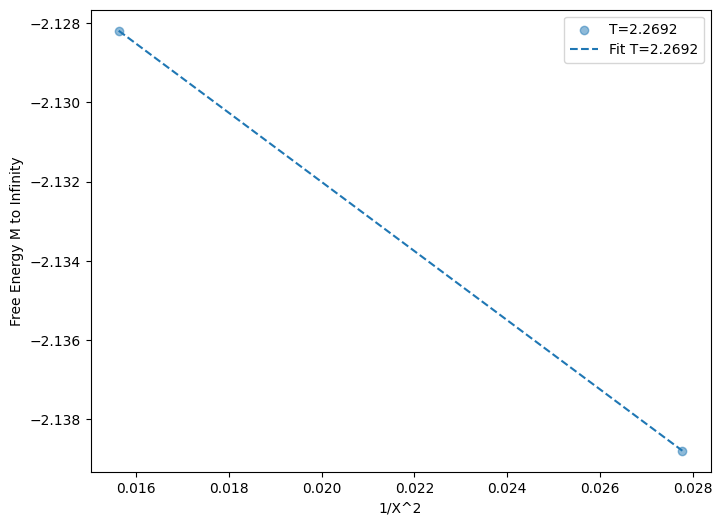

In [8]:
# Get central charge by linear fit of 1/N**2 dependency
c=[]

intercepts_df['inverse_x_squared'] = 1 / (intercepts_df['x_value'] ** 2)

unique_temps = intercepts_df['temp_value'].unique()

plt.figure(figsize=(8, 6))


for t_val in unique_temps:
    temp_df = intercepts_df[intercepts_df['temp_value'] == t_val]
    if len(temp_df) > 1:
#---------------------
        popt, pcov = curve_fit(linear_fit, temp_df['inverse_x_squared'], temp_df['intercept_free_energy'])

        # Extract slope and intercept variances
        slope_variance, intercept_variance = np.diag(pcov)
        slope_std_dev = np.sqrt(slope_variance)
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the results
        c.append({
            'temp': t_val,
            'slope': popt[0],
            'intercept': popt[1],
            'slope_std_dev': slope_std_dev,
            'intercept_std_dev': intercept_std_dev
        })

        # Generate x values for plotting the fit line
        x_fit = np.linspace(min(temp_df['inverse_x_squared']), max(temp_df['inverse_x_squared']), 100)
        y_fit = linear_fit(x_fit, *popt)

        plt.scatter(temp_df['inverse_x_squared'], temp_df['intercept_free_energy'], label=f'T={t_val:.4f}', alpha=0.5)
        # plt.errorbar(temp_df['inverse_x_squared'], temp_df['free_energy_M_to_inf'], yerr=intercept_std_dev, fmt='o', color=colors[T.index(t_val)], label=f'T={t_val}', capsize=5)
        plt.plot(x_fit, y_fit, linestyle='--', label=f'Fit T={t_val:.4f}')

# Final plot adjustments
plt.xlabel('1/X^2')
plt.ylabel('Free Energy M to Infinity')
plt.grid(False)
plt.legend()

# Show the plot
plt.show()
#----------------------


In [9]:
for res in c:
    res['c']=-6*res['slope']/(res['temp']*mp.pi)
    res['c_std_dev']=-6*res['slope_std_dev']/(res['temp']*mp.pi)

c_df = pd.DataFrame(c)

In [10]:
c_df

,temp,slope,intercept,slope_std_dev,intercept_std_dev,c,c_std_dev
0,2.269185,-0.87271,-2.114552,inf,inf,0.73451638338961447060170771035121581368937480...,-inf


/tmp/ipykernel_3548815/4173163654.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


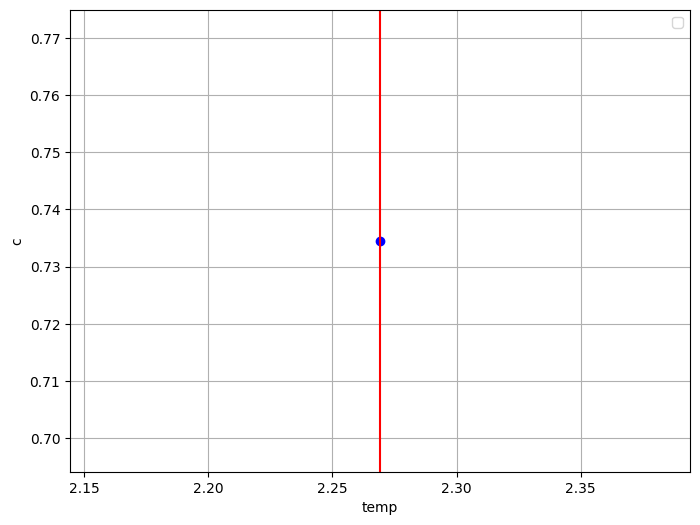

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter( c_df['temp'], c_df['c'], color='blue')
plt.xlabel('temp')
plt.ylabel('c')
plt.axvline(x=T_c, color='red')
plt.grid(True)
plt.legend()
plt.show()

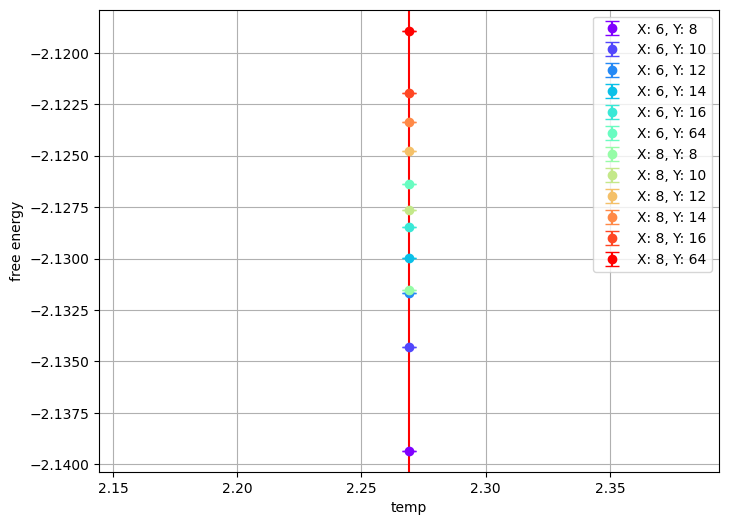

In [12]:
aggregated_results_df

plt.figure(figsize=(8, 6))
unique_keys = results_df.groupby(['x', 'y']).size().reset_index().drop(columns=0)


colors = cm.rainbow(np.linspace(0, 1, len(unique_keys)))

for idx, (x,y) in unique_keys.iterrows():
    xy_df = aggregated_results_df[(aggregated_results_df['x'] == x) & (aggregated_results_df['y'] == y)]
    # plt.plot(xy_df['temp'], xy_df['avg_free_energy'])
    plt.errorbar(
            xy_df['temp'],
            xy_df['avg_free_energy']/(x*y),
            yerr=xy_df['var_free_energy']/(x*y)**2,
            fmt='o', capsize=5, label=f'X: {x}, Y: {y}',
            color = colors[idx]
        )
plt.xlabel('temp')
plt.ylabel('free energy')
plt.axvline(x=T_c, color='red')
plt.grid(True)
plt.legend()
plt.show()